<a href="https://colab.research.google.com/github/ryanhantruong/cbis-ddsm-classifier/blob/main/Segmentation_v3_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install -q git+https://github.com/tensorflow/examples.git
#!pip install --upgrade --user tensorflow_datasets
!git clone https://github.com/matterport/Mask_RCNN.git
!pip install tensorflow==1.15.0
!pip install keras==2.1.5
#!ls -l


Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 38.96 MiB/s, done.
Resolving deltas: 100% (562/562), done.
     |████████████████████████████████| 412.3MB 39kB/s 
     |████████████████████████████████| 3.8MB 50.8MB/s 
     |████████████████████████████████| 512kB 57.3MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=8b158afa4bac0e7dae0be6d979857e381bf0fdcf1831e6edf32aaba7a0ecc0fa
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found exi

In [2]:
import tensorflow as tf
from IPython.display import clear_output
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import skimage
import skimage.morphology
from skimage.measure import label   
import math
import imageio
import shutil
import glob2
from tqdm import tqdm


ROOT_DIR = os.path.abspath("/content/Mask_RCNN/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#print('tfds-version: '+tfds.__version__)

Using TensorFlow backend.


... done downloading pretrained model!


In [ ]:
#!ls -l /content/Mask_RCNN/logs/shapes20210419T2310/events.out.tfevents.1618873876.865a5ae46715

In [3]:
from google.colab import auth
auth.authenticate_user('alangenb')
project_id = 'final-307422'
!gcloud config set project {project_id}
!gsutil ls

Updated property [core/project].
gs://cbis-ddsm-new-patch/
gs://cbis-ddsm-png-reorganized/
gs://cbis-ddsm-prepro-png/
gs://cbis-ddsm-prepro-tf/
gs://cbis-ddsm-tf/


In [ ]:
#!gcloud auth login


In [4]:
#!rm -rf /root/tensorflow_datasets/
!mkdir -p /root/tensorflow_datasets/
!gsutil -m cp -r gs://cbis-ddsm-prepro-png /root/tensorflow_datasets/ 
!ls -l /root/tensorflow_datasets/cbis-ddsm-prepro-png/prepro-png/original-mass
#!rm -rf /root/tensorflow_datasets/curated_breast_imaging_ddsm/

Streaming output truncated to the last 5000 lines.
Copying gs://cbis-ddsm-prepro-png/prepro-png/original-calc/train/Calc-Training_P_00613_RIGHT_MLO/mask/mask1_000001.png...
Copying gs://cbis-ddsm-prepro-png/prepro-png/original-calc/train/Calc-Training_P_00621_LEFT_CC/image/000000.png...
Copying gs://cbis-ddsm-prepro-png/prepro-png/original-calc/train/Calc-Training_P_00621_LEFT_CC/mask/mask1_000001.png...
Copying gs://cbis-ddsm-prepro-png/prepro-png/original-calc/train/Calc-Training_P_00621_LEFT_MLO/image/000000.png...
Copying gs://cbis-ddsm-prepro-png/prepro-png/original-calc/train/Calc-Training_P_00621_LEFT_MLO/mask/mask1_000001.png...
Copying gs://cbis-ddsm-prepro-png/prepro-png/original-calc/train/Calc-Training_P_00624_LEFT_CC/image/000000.png...
Copying gs://cbis-ddsm-prepro-png/prepro-png/original-calc/train/Calc-Training_P_00624_LEFT_CC/mask/mask1_000001.png...
Copying gs://cbis-ddsm-prepro-png/prepro-png/original-calc/train/Calc-Training_P_00624_LEFT_MLO/image/000000.png...
Copy

In [5]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "mass"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [6]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [7]:
class CBIS_DDSM_Segmentation(utils.Dataset):
  def initialize(self,topdir,subset):
    assert subset in ["train", "test"]
    self.topdir = topdir + subset + "/"
    self.subset = subset
    self.add_class("calc",1,"calc")
    samp_ids = [re.sub(r'.*\/','',x) for x in glob2.glob(self.topdir+'*')]
    for i in tqdm(range(len(samp_ids))):
      image_file = self.topdir + "/" + samp_ids[i] + "/image/000000.png"
      image = imageio.imread(image_file)
      height, width = image.shape[:2]
      self.add_image(
        "calc",
        image_id=i,
        samp_id = samp_ids[i],
        path=image_file,
        width=width,height=height
      )

  def load_image(self,image_id):
    image = skimage.io.imread(self.image_info[image_id]['path'])
    if image.ndim != 3:
      image = skimage.color.gray2rgb(image)
    if image.shape[-1] == 4:
      image = image[..., :3]
    return image

  """
  def load_image(self,image_id):
    image_info = self.image_info[image_id]
    samp_id = image_info["samp_id"]
    image_file = self.topdir + "/" + samp_id + "/image/000000.png"
    image = imageio.imread(image_file) 
    return image
  """

  def load_mask(self,image_id):
    image_info = self.image_info[image_id]
    samp_id = image_info["samp_id"]
    mask_dir = self.topdir + "/" + samp_id + "/mask/"
    mask_files = glob2.glob(mask_dir+"*.png")
    
    mask = np.zeros([image_info["height"],image_info["width"],len(mask_files)],dtype=np.uint8)
    for i in range(len(mask_files)):
      mask_read = imageio.imread(mask_files[i])
      mask[:,:,i] = mask_read
    return mask, np.ones([mask.shape[-1]], dtype=np.int32)

  def image_reference(self,image_id):
    info = self.image_info[image_id]
    if info["source"] == "calc":
      return info["path"]
    else:
      super(self.__class__,self).image_reference(image_id)

In [8]:
#dataset_train.image_info[0]

In [9]:
topdir = '/root/tensorflow_datasets/cbis-ddsm-prepro-png/prepro-png/original-mass/'

# Training dataset
dataset_train = CBIS_DDSM_Segmentation()
dataset_train.initialize(topdir,'train')
dataset_train.prepare()

# Validation dataset
dataset_val = CBIS_DDSM_Segmentation()
dataset_val.initialize(topdir,'test')
dataset_val.prepare()

100%|██████████| 350/350 [01:12<00:00,  4.82it/s]


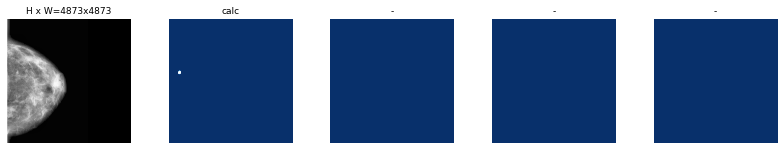

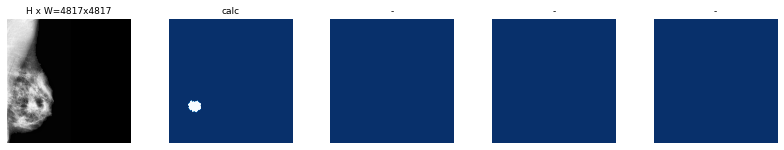

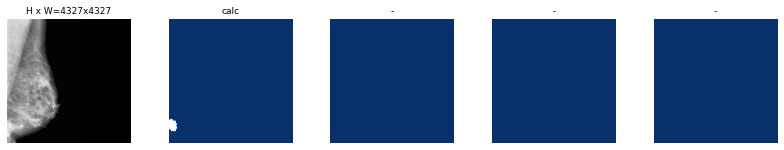

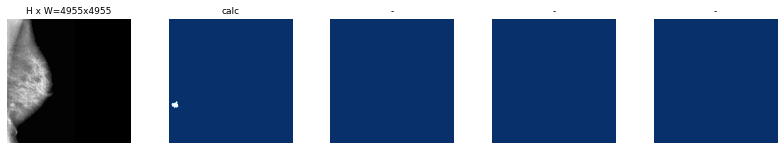

In [10]:
# Load and display random samples
image_ids0 = [re.sub(r'.*\/','',x) for x in glob2.glob(topdir+'train/*')]
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [11]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [12]:
# Which weights to start with?
init_with = "coco"

if init_with == "imagenet":
  model.load_weights(model.get_imagenet_weights(), by_names=True)
elif init_with == "coco":
  model.load_weights(COCO_MODEL_PATH, by_name=True,
                     exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                              "mrccn_bbox", "mrcnn_mask"])
elif init_with == "last":
  model.load_weights(model.find_last(), by_name=True)

In [13]:
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=1,
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/Mask_RCNN/logs/mass20210420T2344/mask_rcnn_mass_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4   

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/1
 99/100 [============================>.] - ETA: 2s - loss: 2.4745 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 1.0329 - mrcnn_class_loss: 0.2248 - mrcnn_bbox_loss: 0.6142 - mrcnn_mask_loss: 0.5686

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


100/100 [==============================] - 317s 3s/step - loss: 2.4654 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 1.0262 - mrcnn_class_loss: 0.2251 - mrcnn_bbox_loss: 0.6131 - mrcnn_mask_loss: 0.5670 - val_loss: 1.7661 - val_rpn_class_loss: 0.0258 - val_rpn_bbox_loss: 0.4401 - val_mrcnn_class_loss: 0.2604 - val_mrcnn_bbox_loss: 0.5699 - val_mrcnn_mask_loss: 0.4699



ERROR:root:Error processing image {'id': 476, 'source': 'calc', 'path': '/root/tensorflow_datasets/cbis-ddsm-prepro-png/prepro-png/original-mass/train//Mass-Training_P_00927_LEFT_MLO/image/000000.png', 'samp_id': 'Mass-Training_P_00927_LEFT_MLO', 'width': 4955, 'height': 4955}
Traceback (most recent call last):
  File "/content/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/Mask_RCNN/mrcnn/model.py", line 1212, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-7-b03f90cf6ad4>", line 46, in load_mask
    mask[:,:,i] = mask_read
ValueError: could not broadcast input array from shape (4311,4311) into shape (4955,4955)


In [14]:
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2,
            layers="all")



Starting at epoch 1. LR=0.0001

Checkpoint Path: /content/Mask_RCNN/logs/mass20210420T2344/mask_rcnn_mass_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b   

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessi

Epoch 2/2


ERROR:root:Error processing image {'id': 476, 'source': 'calc', 'path': '/root/tensorflow_datasets/cbis-ddsm-prepro-png/prepro-png/original-mass/train//Mass-Training_P_00927_LEFT_MLO/image/000000.png', 'samp_id': 'Mass-Training_P_00927_LEFT_MLO', 'width': 4955, 'height': 4955}
Traceback (most recent call last):
  File "/content/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/Mask_RCNN/mrcnn/model.py", line 1212, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-7-b03f90cf6ad4>", line 46, in load_mask
    mask[:,:,i] = mask_read
ValueError: could not broadcast input array from shape (4311,4311) into shape (4955,4955)


 99/100 [============================>.] - ETA: 2s - loss: 1.5348 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 0.4636 - mrcnn_class_loss: 0.1613 - mrcnn_bbox_loss: 0.4344 - mrcnn_mask_loss: 0.4521

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


100/100 [==============================] - 334s 3s/step - loss: 1.5306 - rpn_class_loss: 0.0233 - rpn_bbox_loss: 0.4610 - mrcnn_class_loss: 0.1612 - mrcnn_bbox_loss: 0.4332 - mrcnn_mask_loss: 0.4519 - val_loss: 1.6660 - val_rpn_class_loss: 0.0247 - val_rpn_bbox_loss: 0.6981 - val_mrcnn_class_loss: 0.1435 - val_mrcnn_bbox_loss: 0.4052 - val_mrcnn_mask_loss: 0.3945


In [15]:
# DETECTION
class InferenceConfig(ShapesConfig):
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode="inference",
                          config=inference_config,
                          model_dir=MODEL_DIR)

model_path = model.find_last()

print("Loading weights from ",model_path)
model.load_weights(model_path, by_name=True)




Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/Mask_RCNN/logs/mass20210420T2344/mask_rcnn_mass_0002.h5
Re-starting from epoch 2


original_image           shape: (512, 512, 3)         min:    0.00000  max:  253.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 4187.00000  float64
gt_class_id              shape: (2,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (2, 4)                min:   22.00000  max:  171.00000  int32
gt_mask                  shape: (512, 512, 2)         min:    0.00000  max:    1.00000  uint8


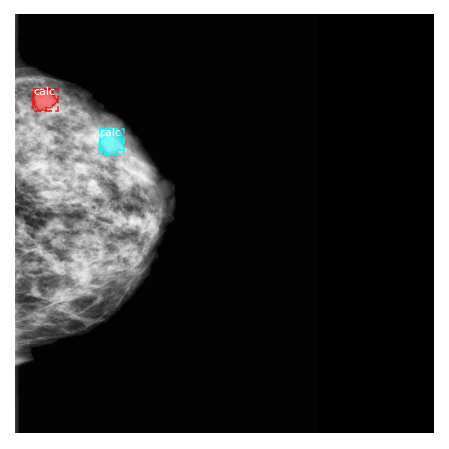

In [24]:
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
  modellib.load_image_gt(dataset_val, inference_config,
                         image_id, use_mini_mask=False)

log("original_image",original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
                            dataset_train.class_names, figsize=(8,8))

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


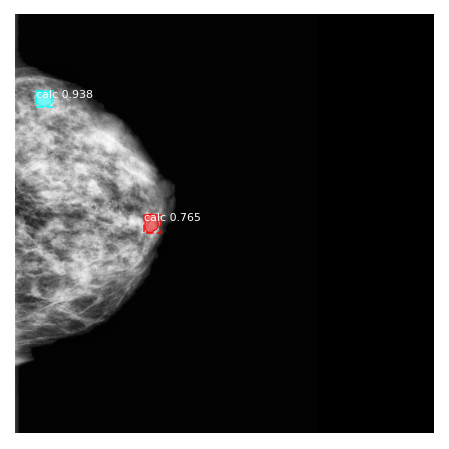

In [25]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                            dataset_val.class_names, r['scores'], ax=get_ax())


In [26]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.4083333333333333
